# Introduction

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Companies like Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data (e.g., including telco and transactional information) to predict their clients' repayment abilities. By using various Statistical Machine Learning methods we unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

<img src="image/loan.jpg" width="450">

## Problem

- Home Credit has to struggle to find out trustworthy clients who be able to repay their loan.
- Home Credit needs to find best segment of clients by age and occupation in order to focusing their marketing strategy on.
- There are `24.825` out of `307.511` clients with late payment, that is `8,1 %` of total clients.

## Objective

- To use historical loan application data to predict whether or not an applicant will be able to repay a loan.
- To find out Home Credit's best segment of clients by age and occupation.
- To find out what type of clients are not able to repay their loan.

## Methodology

- Machine learning algorithm using Logistic Regression and LightGBM.
- Exploratory Data Analysis.

## The dataset

There are 7 different sources of data:

- `application_{train|test}.csv`
    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    - Static data for all applications. One row represents one loan in our data sample.
- `bureau.csv`
    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
- `bureau_balance.csv`
    - Monthly balances of previous credits in Credit Bureau.
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
- `POS_CASH_balance.csv`
    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
- `credit_card_balance.csv`
    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
- `previous_application.csv`
    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.
- `installments_payments.csv`
    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    - There is a) one row for every payment that was made plus b) one row each for missed payment.
    - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
- `HomeCredit_columns_description.csv`
    - This file contains descriptions for the columns in the various data files.

<img src="image/erd_loan.jpg" width="800">

# Load data and library

In [1]:
# import basic library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
pd.options.display.max_columns = None
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import sys

In [2]:
path = 'dataset/'

# main data
app_train = pd.read_csv(path + 'application_train.csv')
app_test = pd.read_csv(path + 'application_test.csv')

# additional data
bureau = pd.read_csv(path + 'bureau.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
previous_app = pd.read_csv(path + 'previous_application.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
POS_CASH_balance = pd.read_csv(path + 'POS_CASH_balance.csv')

# column descriptions
description = pd.read_csv(path + 'HomeCredit_columns_description.csv', usecols = ['Row', 'Description'])

In [3]:
def check_memory_usage(var):
    print('%s KB'%(sys.getsizeof(var)/1000))

# Data understanding and cleaning

## Total features

- The main data used for training is `app_train` and for testing is `app_test`.
- The difference between `app_train` and `app_test` are only on their shapes where `TARGET` column is provided in `app_train`.

In [4]:
print('training data shape:', app_train.shape)
display(app_train.head())

print('testing data shape:', app_test.shape)
display(app_test.head())

training data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

testing data shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [5]:
total_features = list(app_train.columns) + list(app_test.columns) + \
                 list(bureau.columns) + list(bureau_balance.columns) + \
                 list(previous_app.columns) + list(credit_card_balance.columns) + list(installments_payments.columns) + list(POS_CASH_balance.columns)
print('total unique features from 7 sources of data:', len(set(total_features)))

total unique features from 7 sources of data: 195


## Class distribution

- The class distribution is imbalance. We will use weighted class technique when building machine learning to balance the class.

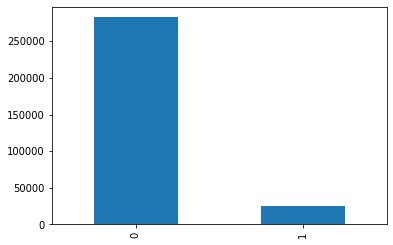

In [6]:
app_train['TARGET'].value_counts().plot(kind = 'bar')
plt.show()

## Data types and check data values

- The data types and values seem reasonable and valid for most of them.
- There are too many unique values in `ORGANIZATION_TYPE`. We could reduce these number into more general organization without their type granularities. (e.g. "Business Entity Type 1", "Business Entity Type 2", and "Business Entity Type 3" into "Business Entity")
- There is also XNA value which represents NaN in `ORGANIZATION_TYPE` and `CODE_GENDER`. We will replace with the mode for `CODE_GENDER` and replace with "Other" for `ORGANIZATION_TYPE`.
- The `DAYS_...` feature names (e.g. `DAYS_BIRTH`, `DAYS_EMPLOYED`, etc) are all in negative values meaning that they are calculated relative to the current loan application date.
- There is anomaly value in `DAYS_EMPLOYED`. The max values is `365243` days i.e. `1000` years! This seems to be error input since the proper values should be negative values. We will replace this value with the lowest negative values.

In [7]:
def descriptive_stats_table(df, dtypes):
    for dtype in dtypes:
        display(df.select_dtypes(dtype).describe())

In [8]:
print(app_train.dtypes.value_counts())
descriptive_stats_table(app_train, ['float64', 'int64', 'object'])

float64    65
int64      41
object     16
dtype: int64


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,0.081184,0.092576,0.110565,0.047732,0.069523,0.107936,0.084307,0.064575,0.110111,0.074445,0.132256,0.100977,0.143709,0.161160,0.081750,0.097880,0.111845,0.046276,0.070254,0.109076,0.082179,0.059897,0.112066,0.076144,0.134467,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.3

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0000

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


In [9]:
# replace the 'ORGANIZATION_TYPE' unique values into more general form
mapper = dict()
for val in app_train.ORGANIZATION_TYPE.value_counts().sort_index().index:
    if val.find('Business Entity') != -1:
        mapper[val] = 'Business Entity'
    elif val.find('Industry') != -1:
        mapper[val] = 'Industry'
    elif val.find('Trade') != -1:
        mapper[val] = 'Trade'
    elif val.find('Transport') != -1:
        mapper[val] = 'Transport'
    elif val.find('XNA') != -1:
        mapper[val] = 'Other'
print(mapper)

app_train['ORGANIZATION_TYPE'] = app_train['ORGANIZATION_TYPE'].replace(mapper)
app_test['ORGANIZATION_TYPE'] = app_test['ORGANIZATION_TYPE'].replace(mapper)

{'Business Entity Type 1': 'Business Entity', 'Business Entity Type 2': 'Business Entity', 'Business Entity Type 3': 'Business Entity', 'Industry: type 1': 'Industry', 'Industry: type 10': 'Industry', 'Industry: type 11': 'Industry', 'Industry: type 12': 'Industry', 'Industry: type 13': 'Industry', 'Industry: type 2': 'Industry', 'Industry: type 3': 'Industry', 'Industry: type 4': 'Industry', 'Industry: type 5': 'Industry', 'Industry: type 6': 'Industry', 'Industry: type 7': 'Industry', 'Industry: type 8': 'Industry', 'Industry: type 9': 'Industry', 'Trade: type 1': 'Trade', 'Trade: type 2': 'Trade', 'Trade: type 3': 'Trade', 'Trade: type 4': 'Trade', 'Trade: type 5': 'Trade', 'Trade: type 6': 'Trade', 'Trade: type 7': 'Trade', 'Transport: type 1': 'Transport', 'Transport: type 2': 'Transport', 'Transport: type 3': 'Transport', 'Transport: type 4': 'Transport', 'XNA': 'Other'}


In [10]:
# replace 'XNA' in gender with the mode, i.e. 'F'
app_train['CODE_GENDER'] = app_train['CODE_GENDER'].replace({'XNA':'F'})
app_test['CODE_GENDER'] = app_test['CODE_GENDER'].replace({'XNA':'F'})

In [11]:
# replace anomaly values in 'DAYS_EMPLOYED'
print('list of anomalie values app_train:', app_train[app_train['DAYS_EMPLOYED'] > 0].DAYS_EMPLOYED.unique())
print('list of anomalie values app_test:', app_test[app_test['DAYS_EMPLOYED'] > 0].DAYS_EMPLOYED.unique())

print('min values in DAYS_EMPLOYED app_train:', app_train['DAYS_EMPLOYED'].min())
print('min values in DAYS_EMPLOYED app_test ', app_test['DAYS_EMPLOYED'].min())

app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace({365243:-17912})
app_test['DAYS_EMPLOYED'] = app_test['DAYS_EMPLOYED'].replace({365243:-17463})

list of anomalie values app_train: [365243]
list of anomalie values app_test: [365243]
min values in DAYS_EMPLOYED app_train: -17912
min values in DAYS_EMPLOYED app_test  -17463


## Missing values

- No missing values in `bureau_balance`.
- There are some missing values in the dataframes. Two techniques to handle the missing values are used and then they will be compared when conducting modeling:
    - To use median/mean and mode imputation for numeric and categorical features respectively (for missing values < 80%) and to drop columns with a high percentage of missing values (for missing values > 80%).
    - To use models such as Gradient Boosted Trees Framework that can handle missing values with no need for imputation and drop columns.


In [12]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1).rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table['Total Rows'] = df.shape[0]
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending = False).round(3)
    print('You are selecting dataframe which has "{}" columns'.format(df.shape[1]))      
    print('There are "{}" columns that have missing values.'.format(mis_val_table.shape[0]))
    return mis_val_table

In [13]:
missing_values_table(app_train).head()

You are selecting dataframe which has "122" columns
There are "67" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
COMMONAREA_MEDI,214865,69.872,307511
COMMONAREA_AVG,214865,69.872,307511
COMMONAREA_MODE,214865,69.872,307511
NONLIVINGAPARTMENTS_MEDI,213514,69.433,307511
NONLIVINGAPARTMENTS_MODE,213514,69.433,307511


In [14]:
missing_values_table(app_test).head()

You are selecting dataframe which has "121" columns
There are "64" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
COMMONAREA_MODE,33495,68.716,48744
COMMONAREA_MEDI,33495,68.716,48744
COMMONAREA_AVG,33495,68.716,48744
NONLIVINGAPARTMENTS_MEDI,33347,68.413,48744
NONLIVINGAPARTMENTS_AVG,33347,68.413,48744


In [15]:
missing_values_table(bureau).head()

You are selecting dataframe which has "17" columns
There are "7" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
AMT_ANNUITY,1226791,71.473,1716428
AMT_CREDIT_MAX_OVERDUE,1124488,65.513,1716428
DAYS_ENDDATE_FACT,633653,36.917,1716428
AMT_CREDIT_SUM_LIMIT,591780,34.477,1716428
AMT_CREDIT_SUM_DEBT,257669,15.012,1716428


In [16]:
missing_values_table(bureau_balance).head()

You are selecting dataframe which has "3" columns
There are "0" columns that have missing values.


,Missing Values,% of Total Values,Total Rows


In [17]:
missing_values_table(previous_app).head()

You are selecting dataframe which has "37" columns
There are "16" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
RATE_INTEREST_PRIMARY,1664263,99.644,1670214
RATE_INTEREST_PRIVILEGED,1664263,99.644,1670214
AMT_DOWN_PAYMENT,895844,53.636,1670214
RATE_DOWN_PAYMENT,895844,53.636,1670214
NAME_TYPE_SUITE,820405,49.120,1670214


In [18]:
missing_values_table(credit_card_balance).head()

You are selecting dataframe which has "23" columns
There are "9" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
AMT_PAYMENT_CURRENT,767988,19.998,3840312
AMT_DRAWINGS_ATM_CURRENT,749816,19.525,3840312
AMT_DRAWINGS_OTHER_CURRENT,749816,19.525,3840312
AMT_DRAWINGS_POS_CURRENT,749816,19.525,3840312
CNT_DRAWINGS_ATM_CURRENT,749816,19.525,3840312


In [19]:
missing_values_table(installments_payments).head()

You are selecting dataframe which has "8" columns
There are "2" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
DAYS_ENTRY_PAYMENT,2905,0.021,13605401
AMT_PAYMENT,2905,0.021,13605401


In [20]:
missing_values_table(POS_CASH_balance).head()

You are selecting dataframe which has "8" columns
There are "2" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
CNT_INSTALMENT_FUTURE,26087,0.261,10001358
CNT_INSTALMENT,26071,0.261,10001358


## Check duplicates

- No duplicate observations in both `app_train` and `app_test`.

In [21]:
app_train[app_train.duplicated(subset = 'SK_ID_CURR')].shape

(0, 122)

In [22]:
app_test[app_test.duplicated(subset = 'SK_ID_CURR')].shape

(0, 121)

# Exploratory Data Analysis

## Preliminary feature selection using hypothesis testing

Since we deal with huge amount of features, we will perform feature selection first using hypothesis testing. We will use ANOVA test for numeric features and Chi-Squared test for categorical features. Then, we'll find and examine the top 5 significant features for both numeric and categorical features.

### ANOVA test

- From the ANOVA test, the top 5 important features (the smallest p-values) are `EXT_SOURCE_3`, `EXT_SOURCE_2`, `EXT_SOURCE_1`, `DAYS_BIRTH`, `REGION_RATING_CLIENT_W_CITY`.
- The significant features from ANOVA test is stored in `num_columns`.

In [23]:
# helper function to perform ANOVA test
import pingouin
def ANOVA_test(df, columns, target, alpha = 0.05):
    p_value = []; result = []; temp = []
    for col in columns:
        anova_results = pingouin.anova(data = df, dv = col, between = target)
        p = anova_results['p-unc'][0]
        temp.append(col)
        
        # assign the result 
        if abs(p) <= alpha:
            result.append('reject H0 (significant)')
        else:
            result.append('fail to reject H0')
            
        # assign the p-value
        p_value.append(p)
    output = pd.DataFrame({'p_value':p_value, 'result':result}, index = temp)
    output.index.name = '"ANOVA Test"'
    output.columns.name = target
    return output.sort_values('p_value')

In [24]:
# get numerical features from 'app_train'
app_train_anova = app_train.copy().select_dtypes('number')

# perform ANOVA test
ANOVA_results = ANOVA_test(df = app_train_anova, 
                           columns = app_train_anova.drop('TARGET', axis = 1).columns, 
                           target = 'TARGET', alpha = 0.05)
ANOVA_results

TARGET,p_value,result
"""ANOVA Test""",,
EXT_SOURCE_3,0.000000e+00,reject H0 (significant)
EXT_SOURCE_2,0.000000e+00,reject H0 (significant)
EXT_SOURCE_1,0.000000e+00,reject H0 (significant)
DAYS_BIRTH,0.000000e+00,reject H0 (significant)
DAYS_EMPLOYED,8.444512e-301,reject H0 (significant)
...,...,...
AMT_REQ_CREDIT_BUREAU_WEEK,6.845546e-01,fail to reject H0
FLAG_MOBIL,7.669698e-01,fail to reject H0
FLAG_CONT_MOBILE,8.373783e-01,fail to reject H0


In [25]:
# select the significant features
num_columns = list(ANOVA_results[ANOVA_results.result == 'reject H0 (significant)'].index)

print('''From {} numerical features, we drop {} features\n---> hence, we have selected {} significant numerical features'''.format(len(ANOVA_results.index), len(ANOVA_results.index) - len(num_columns), len(num_columns)))

From 105 numerical features, we drop 20 features
---> hence, we have selected 85 significant numerical features


### Chi-Squared test

- From the Chi-Squared test, the top 5 important features (the smallest p-values) are `ORGANIZATION_TYPE`, `OCCUPATION_TYPE`, `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `CODE_GENDER`.
- The significant features from Chi-Squared test is stored in `cat_columns`.

In [26]:
# helper function to perform chi-squared test
from scipy.stats import chi2_contingency, chi2
def chi_squared_test(df, crosstab_table, target, prob = 0.95):
    result = crosstab_table.copy()
    p_value = crosstab_table.copy()
    for index in crosstab_table.index:
        for column in crosstab_table.columns:
            # contingency table
            temp_table = pd.crosstab(df[index], df[column])
            
            # perform Chi-Squared Test from contingency table
            stat, p, dof, expected = chi2_contingency(temp_table)
            
            # compute the critical value
            critical = chi2.ppf(prob, dof)
            
            # assign the result 
            if abs(stat) >= critical:
                result.loc[index, column] = 'reject H0 (significant)'
            else:
                result.loc[index, column] = 'fail to reject H0'
            
            # assign the p-value
            p_value.loc[index, column] = p
            
    output = pd.concat([p_value.loc[:, [target]], result.loc[:, [target]]], axis = 1)
    output.index.name = '"Chi-Squared Test"'
    output.columns = ['p_value', 'result']
    output.columns.name = target
    return result, p_value, output.sort_values('p_value')

In [27]:
# get categorical features from 'app_train'
app_train_chi = app_train.copy().select_dtypes('object')
app_train_chi['TARGET'] = app_train['TARGET'].copy()

# perform chi-squared test on 'cat_columns'
crosstab_table = pd.crosstab(app_train_chi.columns, app_train_chi.columns)                           
_, _, CHI_SQUARED_results = chi_squared_test(app_train_chi, crosstab_table, target = 'TARGET', prob = 0.95)
CHI_SQUARED_results

TARGET,p_value,result
"""Chi-Squared Test""",,
TARGET,0.000000e+00,reject H0 (significant)
OCCUPATION_TYPE,3.784500e-288,reject H0 (significant)
NAME_INCOME_TYPE,1.928146e-266,reject H0 (significant)
ORGANIZATION_TYPE,6.582184e-257,reject H0 (significant)
NAME_EDUCATION_TYPE,2.447681e-219,reject H0 (significant)
CODE_GENDER,4.183493e-202,reject H0 (significant)
NAME_FAMILY_STATUS,7.744842e-107,reject H0 (significant)
NAME_HOUSING_TYPE,1.099089e-88,reject H0 (significant)
NAME_CONTRACT_TYPE,1.023515e-65,reject H0 (significant)


In [28]:
# select the significant features
cat_columns = list(CHI_SQUARED_results[CHI_SQUARED_results.result == 'reject H0 (significant)'].index)
cat_columns.remove('TARGET')
print('''From {} categorical features, we drop {} features\n---> hence, we have selected {} significant categorical features'''.format(len(CHI_SQUARED_results.index)-1, len(CHI_SQUARED_results.index)-1 - len(cat_columns), len(cat_columns)))

From 16 categorical features, we drop 0 features
---> hence, we have selected 16 significant categorical features


## General data distribution

### Numerical features

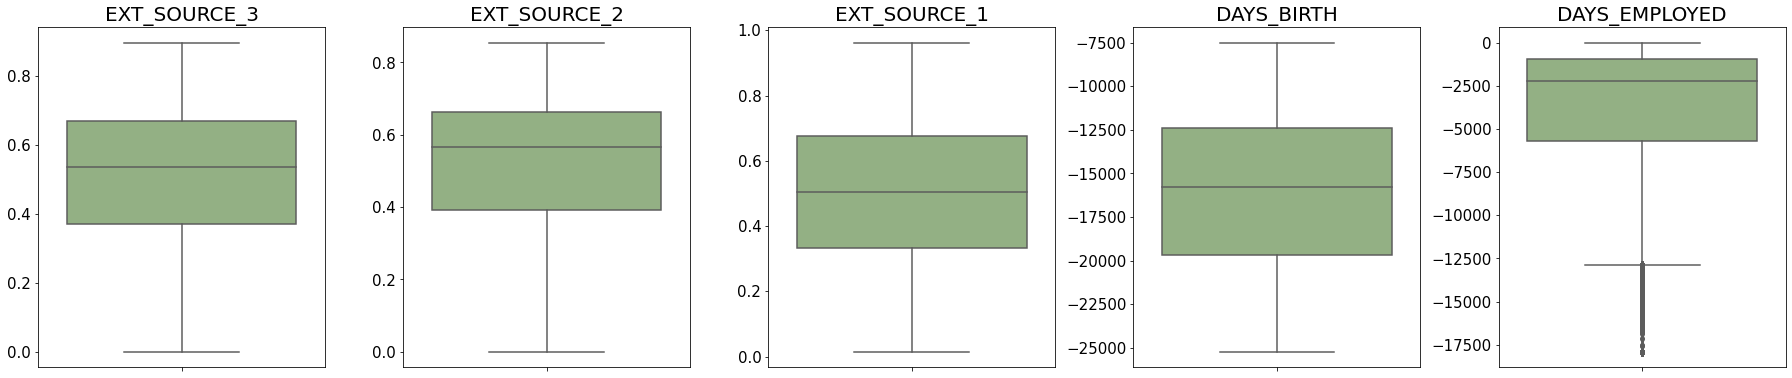

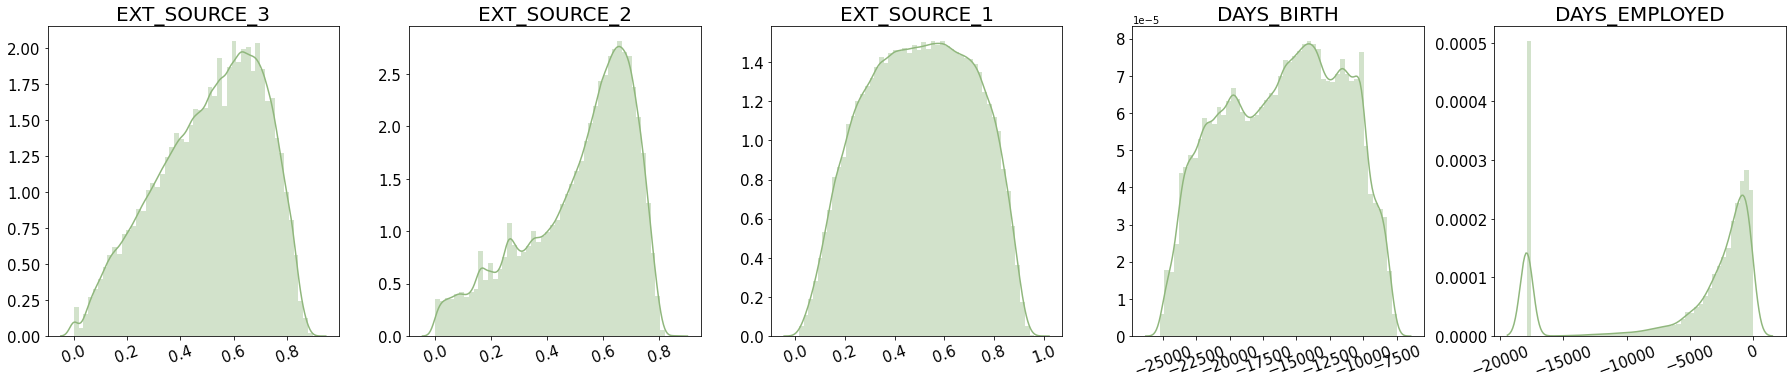

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_EMPLOYED
count,246546.000000,3.068510e+05,134133.000000,307511.000000,307511.000000
mean,0.510853,5.143927e-01,0.502130,-16036.995067,-5180.290751
std,0.194844,1.910602e-01,0.211062,4363.988632,6331.100000
min,0.000527,8.173617e-08,0.014568,-25229.000000,-17912.000000
25%,0.370650,3.924574e-01,0.334007,-19682.000000,-5707.000000
50%,0.535276,5.659614e-01,0.505998,-15750.000000,-2219.000000
75%,0.669057,6.636171e-01,0.675053,-12413.000000,-933.000000
max,0.896010,8.549997e-01,0.962693,-7489.000000,0.000000


In [29]:
# 'num_columns[:5]' data
fig = plt.figure(figsize = (25, 25))
i = 1
for col in app_train[num_columns[:5]].columns:
    plt.subplot(5, 5, i)
    ax = sns.boxplot(y = app_train[col], color = '#90B77D')

    ax.set(xlabel = None, ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 20)
    plt.xticks(rotation = 20, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.tight_layout()
    i += 1
plt.show()

fig = plt.figure(figsize = (25, 25))
i = 1
for col in app_train[num_columns[:5]].columns:
    plt.subplot(5, 5, i)
    ax = sns.distplot(x = app_train[col], color = '#90B77D')

    ax.set(xlabel = None, ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 20)
    plt.xticks(rotation = 20, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.tight_layout()
    i += 1
plt.show()

# compute the descriptive stats of 'num_columns[:5]'
app_train[num_columns[:5]].describe()

### Categorical features

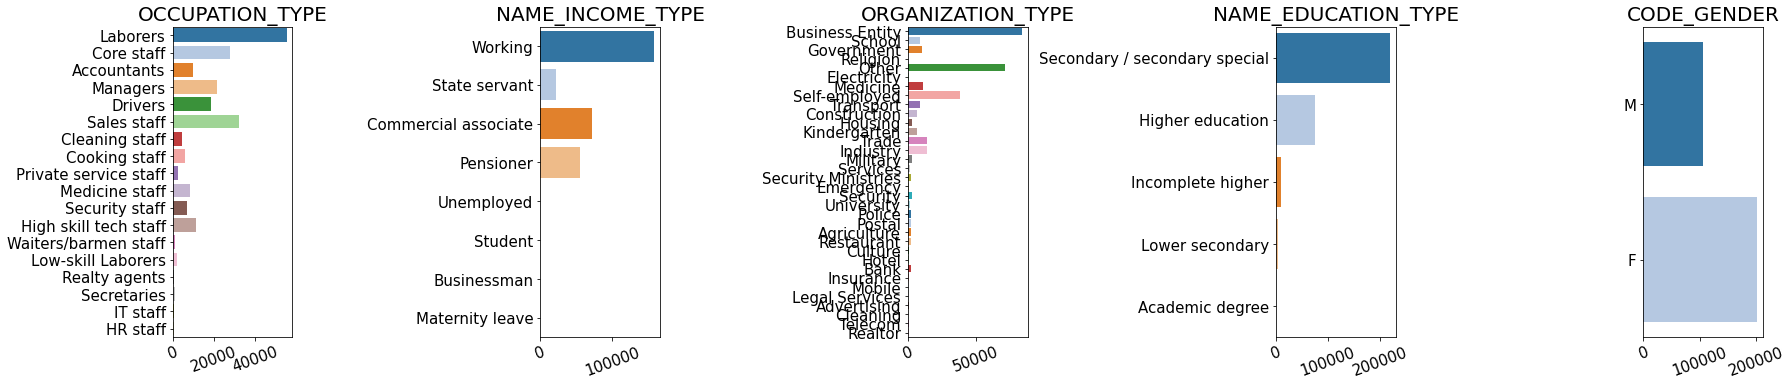

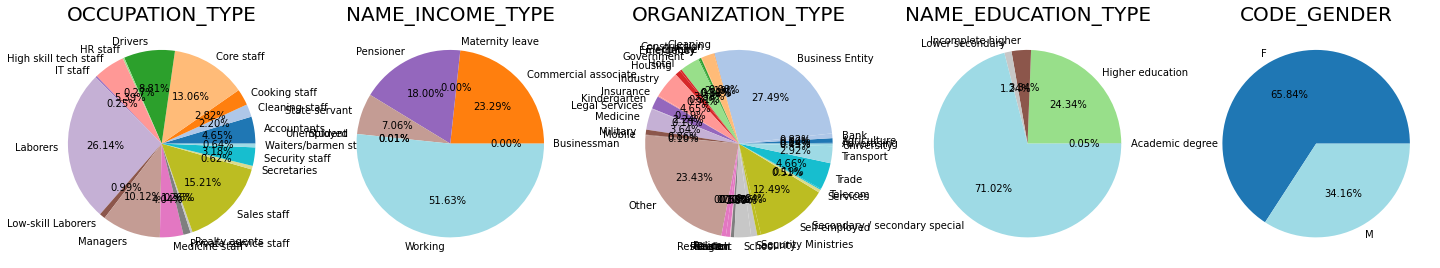

,OCCUPATION_TYPE,NAME_INCOME_TYPE,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,CODE_GENDER
count,211120,307511,307511,307511,307511
unique,18,8,34,5,2
top,Laborers,Working,Business Entity,Secondary / secondary special,F
freq,55186,158774,84529,218391,202452


In [30]:
# 'cat_columns[1:6]' data
fig = plt.figure(figsize = (25, 25))
i = 1
for col in app_train[cat_columns[:5]].columns:
    plt.subplot(5, 5, i)
    ax = sns.countplot(data = app_train[cat_columns[:5]], y = app_train[col], palette = 'tab20')
    
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 20)
    plt.xticks(rotation = 20, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.tight_layout()
    i += 1
plt.show()

fig = plt.figure(figsize = (25, 25))
i = 1
for col in app_train[cat_columns[:5]].columns:
    plt.subplot(5, 5, i)
    ax = app_train.groupby([col]).size().plot(kind = 'pie', autopct = '%.2f%%', colormap = 'tab20')
    
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 20)
    i += 1
plt.show()

# compute the descriptive stats of 'cat_columns'
app_train[cat_columns[:5]].describe()

## Data distribution of whether the clients have difficulties with repayment or not

### Numerical features

- In overall, the higher `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`, then the more likely the clients be able to repay their loans. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit score rating made using numerous sources of data.
- For the `DAYS_BIRTH`, the older clients tend to repay their loans. This is straightforward to understand since the more experience clients with their job as they get older, then the more income they have and the more trustworthy they are. **Let's take a look deeper for this feature by transforming into group of age by year in the next section.** 
- For the `DAYS_EMPLOYED`, the longest employed clients tend to repay their loans. This feature might be correlated with `DAYS_BIRTH`. As our intuition, the longest they have been employed then the older the clients.

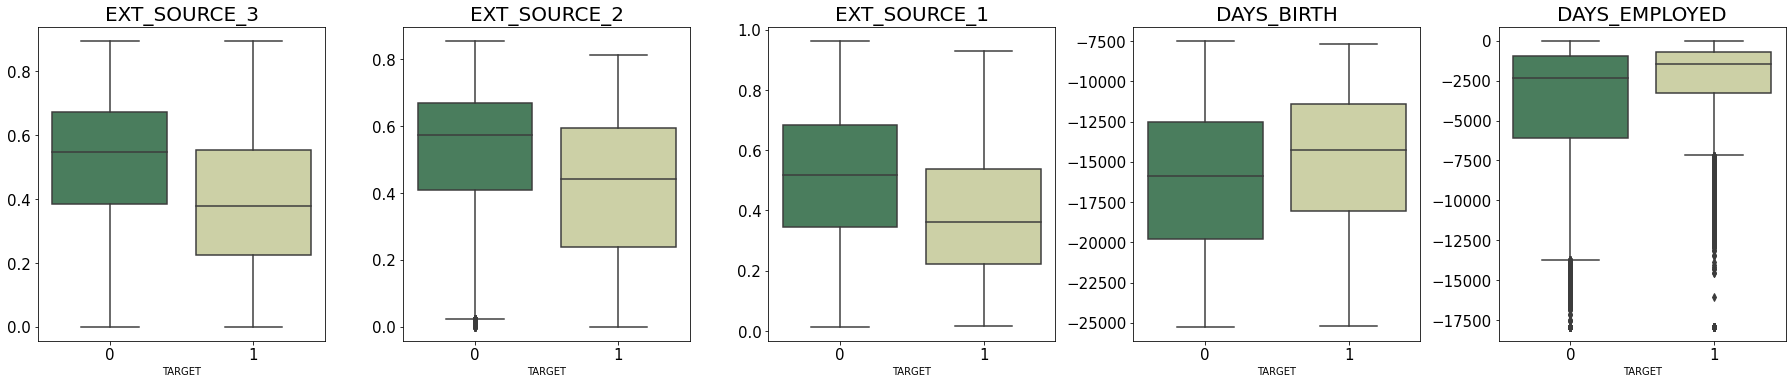

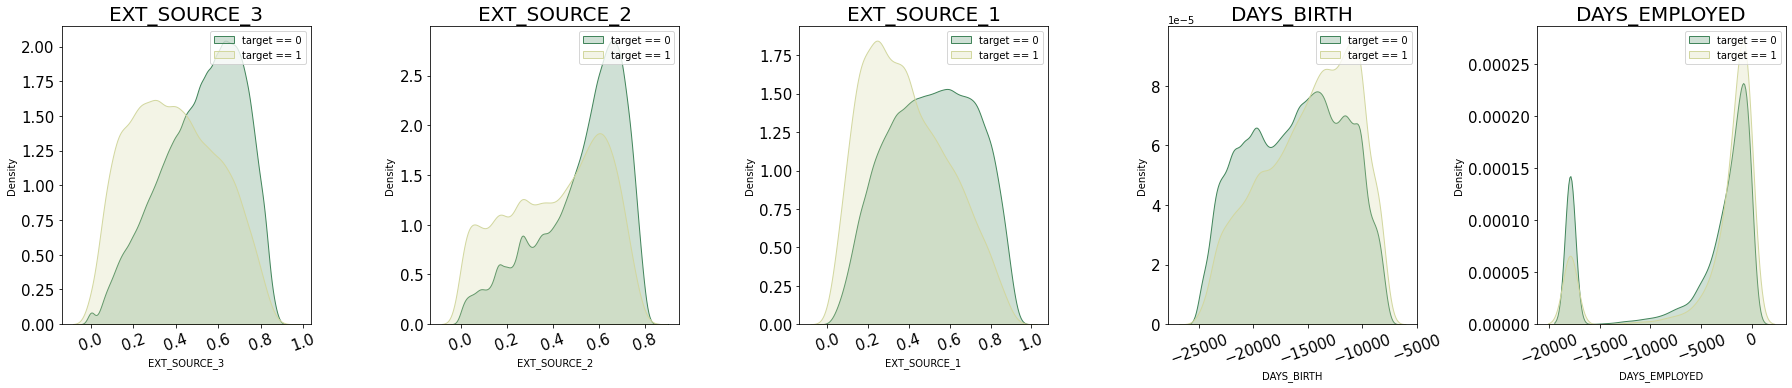

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_EMPLOYED
TARGET,,,,,
0,0.520969,0.523479,0.511461,-16138.176397,-5305.571401
1,0.390717,0.410935,0.386968,-14884.828077,-3753.701188


In [31]:
# 'num_columns[:5]' data
fig = plt.figure(figsize = (25, 25))
i = 1
for col in app_train[num_columns[:5]].columns:
    plt.subplot(5, 5, i)
    ax = sns.boxplot(y = app_train[col], x = app_train['TARGET'], palette = ['#42855B', '#D2D79F'])

    ax.set(ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 20)
    plt.xticks(rotation = 0, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.tight_layout()
    i += 1
plt.show()

fig = plt.figure(figsize = (25, 25))
i = 1
for col in app_train[num_columns[:5]].columns:
    plt.subplot(5, 5, i)
#     ax = sns.histplot(x = app_train[col], hue = app_train['TARGET'], palette = ['#42855B', '#D2D79F'], kde = True)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, col], label = 'target == 0', color = '#42855B', fill=True)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, col], label = 'target == 1', color = '#D2D79F', fill=True)
    
    ax.set(ylabel = None, xlabel = None)
    plt.title(str(col), loc = 'center', fontsize = 20)
    plt.xticks(rotation = 20, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.tight_layout()
    plt.legend()
    i += 1
plt.show()

app_train[num_columns[:5] + ['TARGET']].groupby('TARGET').agg('mean')

### Categorical features

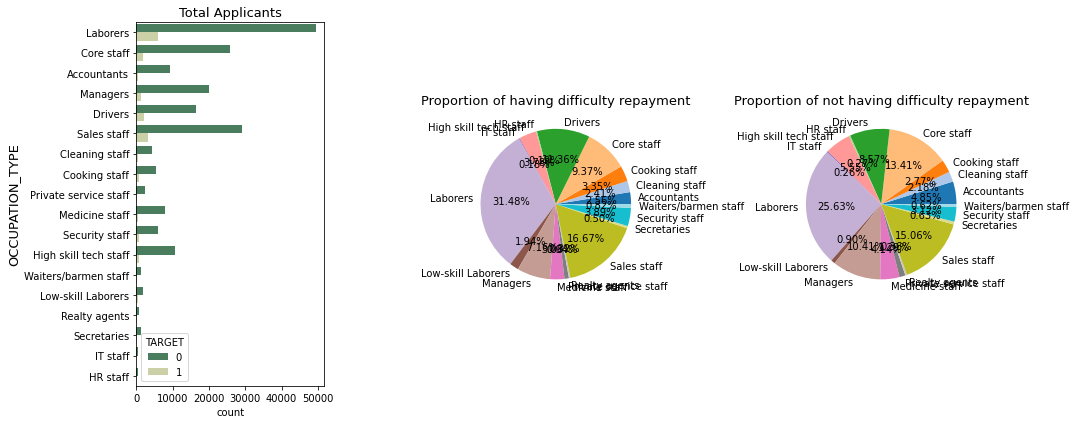

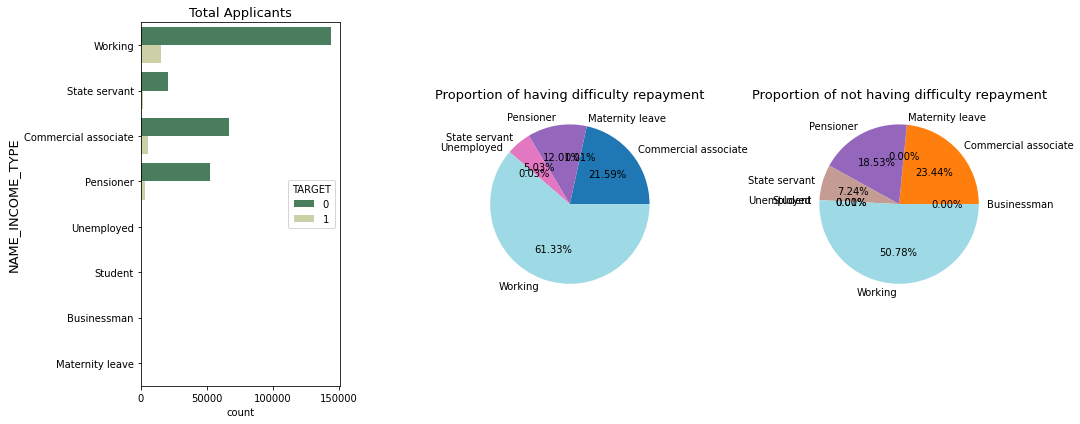

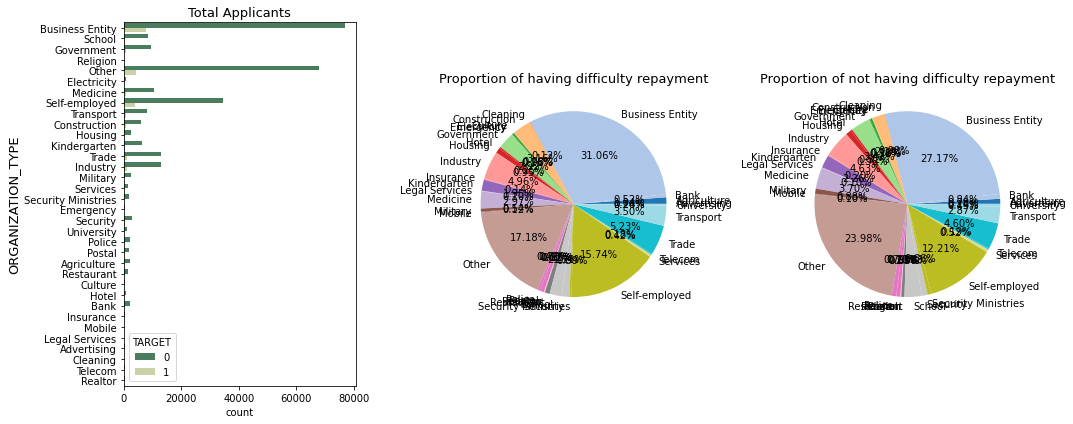

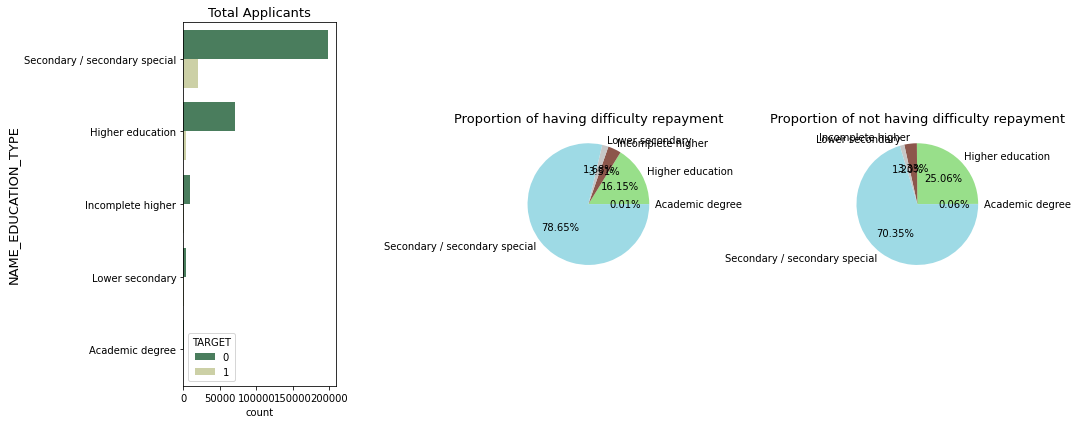

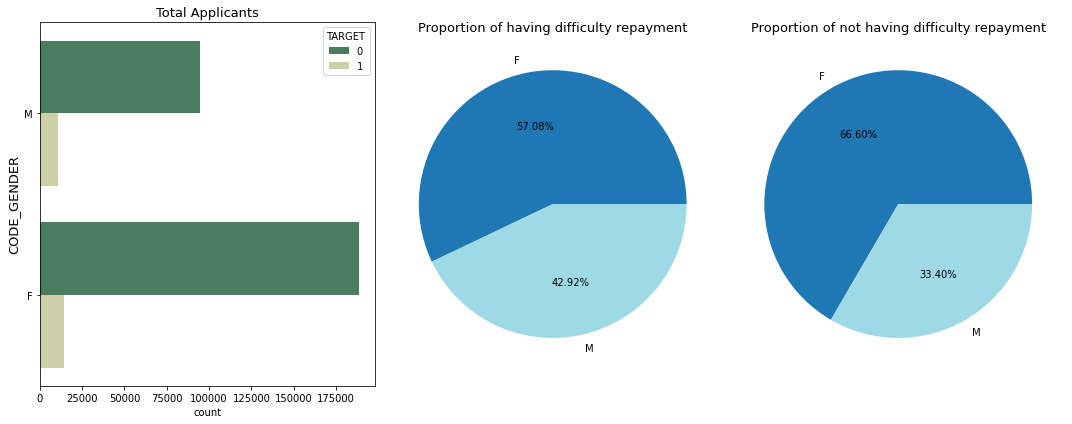

In [32]:
# 'cat_columns[:5]' data
for col in app_train[cat_columns[:5]].columns:
    fig, ax = plt.subplots(figsize = (15, 6), ncols = 3, nrows = 1)
    
    # plot 1: countplot
    sns.countplot(data = app_train, y = app_train[col], hue = 'TARGET', ax = ax[0], palette = ['#42855B', '#D2D79F'])
    ax[0].set_title('Total Applicants', loc = 'center', fontsize = 13)
    ax[0].set_ylabel(str(col), fontsize = 13)
    
    # plot 2: proportion of approved
    _ = app_train[app_train['TARGET'] == 1]
    _.groupby([col]).size().plot(kind = 'pie', autopct = '%.2f%%', ax = ax[1], colormap = 'tab20')
    ax[1].set(xlabel = None, ylabel = None)
    ax[1].set_title('Proportion of having difficulty repayment', loc = 'center', fontsize = 13)
    
    # plot 3: proportion of not approved
    _ = app_train[app_train['TARGET'] == 0]
    _.groupby([col]).size().plot(kind = 'pie', autopct = '%.2f%%', ax = ax[2], colormap = 'tab20')
    ax[2].set(xlabel = None, ylabel = None)
    ax[2].set_title('Proportion of not having difficulty repayment', loc = 'center', fontsize = 13)
    
    plt.tight_layout()
    plt.show()

## Deep dive

- One of the technique to look deeper the data is by using dual-axis graph where the primary axis (left axis) will be the aggregates values from a numeric feature we choose (i.e. sum, average, median, etc) of grouping by unique categories from a categorical feature, then the secondary axis (right axis) will be the aggregated values from a target variable. This will help us to find the proportion of wheter or not a client be able to repay their loan based on grouping by categorical features and compared it with their aggregated values based on selected numerical features.

In [33]:
# helper function to create dual axis graph
def dual_axis_analysis(df, group, primary, secondary, title, figure_size, limit_2nd_axis = [0, 0.5]):
    import math
    columns = 2
    rows = math.ceil(len(primary)/columns)
    fig, ax = plt.subplots(figsize = figure_size, nrows = rows, ncols = columns)
    i = 0
    for row in range(rows):
        for col in range(columns):
            temp_1 = df.groupby(group).agg({list(primary.keys())[i]:list(primary.values())[i]})
            temp_1.columns = ['target']
            temp_1 = temp_1.sort_values(by = 'target', ascending = False)            
            temp_2 = df.groupby(group).agg({list(secondary.keys())[0]:list(secondary.values())[0]}).loc[temp_1.index, :]
            temp_axis = ax[row][col].twinx()
            
            sns.barplot(data = df, x = group, y = list(primary.keys())[i],
                        ax = ax[row][col], palette = 'Greens_r', order = temp_1.index, estimator = list(primary.values())[i])
            temp_2.plot(kind = 'line', 
                        ax = temp_axis, marker = 'o', alpha = 1, color = '#E74C3C', legend = None)
            
            ax[row][col].set(xlabel = None)
            ax[row][col].set_title('{0} (grouby "{1}")'.format(title[i], group))
            ax[row][col].set_ylabel(list(primary.keys())[i], color = '#224B0C', fontsize = 10)
            ax[row][col].tick_params(axis = 'y', labelcolor = '#224B0C')
            ax[row][col].set_xticklabels([label for label in temp_1.index], rotation = 30, ha = 'right', fontsize = 12)
            temp_axis.set_ylabel('Failure to repay (fraction)', color = '#E74C3C', fontsize = 10)
            temp_axis.tick_params(axis = 'y', labelcolor = '#E74C3C')
            temp_axis.set_ylim(limit_2nd_axis[0], limit_2nd_axis[1])
            plt.tight_layout()
            i += 1
    plt.show()

### Group of age of clients: `YEARS_BIRTH_SEGMENT`

- Our base clients have age between 30-45 and the smallest number of clients are in age group 20-25.
- Younger age groups are more likely to have failure repayment, especially age group between 20-25, 25-30, and 30-35 where the failure repayment fraction is above `10%` and below `5%` for the oldest age group.
- Older age group of clients tend to loan more money compared to younger clients.
- Older age group of clients tend to have more `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
- It seems that age has a bit relationship with income.
- **Recommendation**: 
    - The marketing strategy has to be more focus on older age group since in overall they have lower failure repayment rate and higher external source score. Essentially, these groups have better and stable financial condition.
    - As the younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This doesn't mean that Home Credit should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

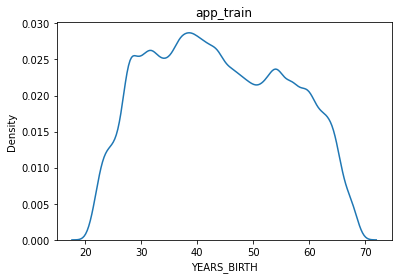

,YEARS_BIRTH_SEGMENT,YEARS_BIRTH
0,"(25, 30]",25.920548
1,"(45, 50]",45.931507
2,"(50, 55]",52.180822
3,"(50, 55]",52.068493
4,"(50, 55]",54.608219


In [34]:
app_train['NUMBER_OF_CLIENTS'] = 1
app_test['NUMBER_OF_CLIENTS'] = 1

# create 'YEARS_BIRTH'
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / -365
app_test['YEARS_BIRTH'] = app_test['DAYS_BIRTH'] / -365

# create 'YEARS_BIRTH_SEGMENT'
app_train['YEARS_BIRTH_SEGMENT'] = pd.cut(app_train['YEARS_BIRTH'], bins = np.arange(0, 71, 5))
app_test['YEARS_BIRTH_SEGMENT'] = pd.cut(app_train['YEARS_BIRTH'], bins = np.arange(0, 71, 5))

# check distribution
sns.kdeplot(app_train.YEARS_BIRTH)
plt.title('app_train')
plt.show()
app_train[['YEARS_BIRTH_SEGMENT', 'YEARS_BIRTH']].head()

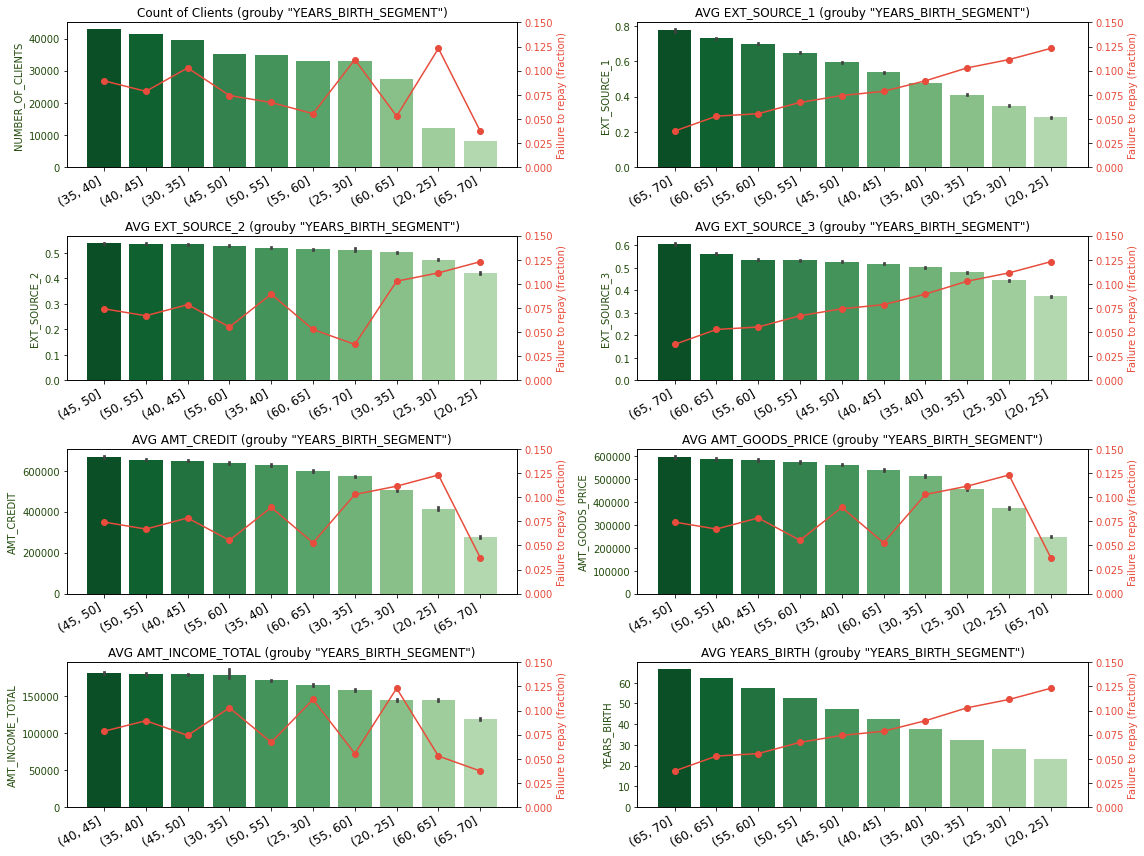

In [35]:
# plot the dual axis graph: 'YEARS_BIRTH_SEGMENT'
primary = {'NUMBER_OF_CLIENTS':np.count_nonzero, 'EXT_SOURCE_1':np.mean,
           'EXT_SOURCE_2':np.mean, 'EXT_SOURCE_3':np.mean,
           'AMT_CREDIT':np.mean, 'AMT_GOODS_PRICE':np.mean,
           'AMT_INCOME_TOTAL':np.mean, 'YEARS_BIRTH':np.mean}
secondary = {'TARGET':np.mean}
title = ['Count of Clients', 'AVG EXT_SOURCE_1', 
         'AVG EXT_SOURCE_2', 'AVG EXT_SOURCE_3',  
         'AVG AMT_CREDIT', 'AVG AMT_GOODS_PRICE',
         'AVG AMT_INCOME_TOTAL', 'AVG YEARS_BIRTH']

dual_axis_analysis(df = app_train, group = 'YEARS_BIRTH_SEGMENT',
                   primary = primary, secondary = secondary,
                   title = title,
                   figure_size = (16, 12), limit_2nd_axis = [0, 0.15])

### Group of occupation type of clients: `OCCUPATION_TYPE`

- Most of the Home Credit's clients are employed as "Laborers" then followed by "Sales staff", "Core staff", and "Managers". Only a few from "IT staff", "HR staff", "Realty agents", and "Secretaries".
- "Low-skill Laborers" have the highest fraction of failure to repay then followed by "Drivers", "Waiters/barmen staff", "Laborers", "Security staff", "Cooking staff", and "Sales staff". "Accountants" have the lowest fraction of failure to repay then followed by "High skill tech staff", "Managers", "Core staff", "HR staff", and "IT staff".
- "Managers" have the highest average income and "Cleaning staff" have the lowest.
- **Recomendation**:
    - As we can see, the higher the level paid job that clients have, then the more likely that clients repay the loan. Hence, we need to put more focus marketing strategy to increase the number of clients with high level paid job such as "IT staff" and "HR staff".
    - We also see most of  Home Credit client's occupation are as "Laborers" (the number of clients are above 40000). Hence we should be more put more attention to these clients such as giving them lower monthly payments, create a special loan program for these clients, or loyalty program for those clients who always repay the loan on time.

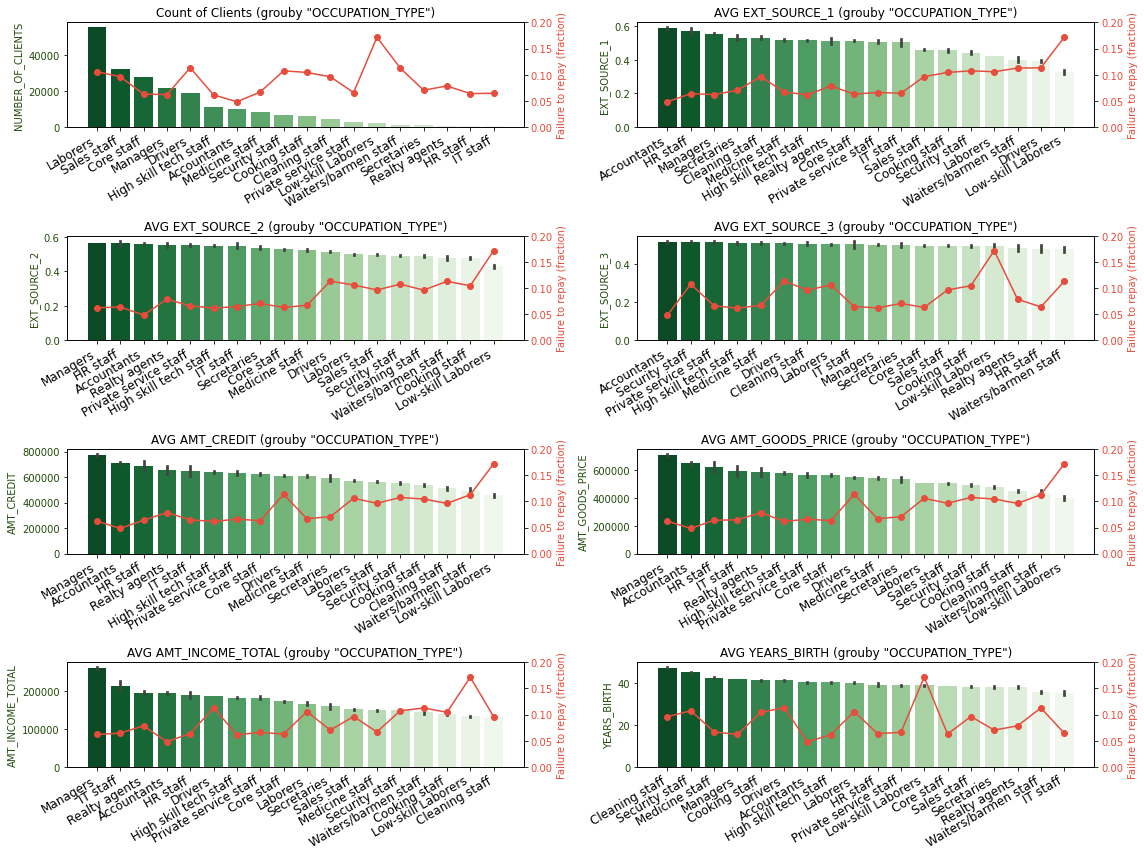

In [36]:
# plot the dual axis graph: 'OCCUPATION_TYPE'
primary = {'NUMBER_OF_CLIENTS':np.count_nonzero, 'EXT_SOURCE_1':np.mean,
           'EXT_SOURCE_2':np.mean, 'EXT_SOURCE_3':np.mean,
           'AMT_CREDIT':np.mean, 'AMT_GOODS_PRICE':np.mean,
           'AMT_INCOME_TOTAL':np.mean, 'YEARS_BIRTH':np.mean}
secondary = {'TARGET':np.mean}
title = ['Count of Clients', 'AVG EXT_SOURCE_1', 
         'AVG EXT_SOURCE_2', 'AVG EXT_SOURCE_3',  
         'AVG AMT_CREDIT', 'AVG AMT_GOODS_PRICE',
         'AVG AMT_INCOME_TOTAL', 'AVG YEARS_BIRTH']

dual_axis_analysis(df = app_train, group = 'OCCUPATION_TYPE',
                   primary = primary, secondary = secondary,
                   title = title,
                   figure_size = (16, 12), limit_2nd_axis = [0, 0.20])

# Feature engineering

Three feature engineering process are conducted:
- Create polynomial features.
- Create features based on domain knowledge.
- Get more features from other data sources (i.e. `bureau`, `bureau_balance`, `previous_app`, `credit_card_balance`, `installments_payments`, and `POS_CASH_balance`) using `groupby` and `agg` methods, then `merge` resulting dataframe by its unique identifier such as `SK_ID_CURR`, `SK_ID_PREV`, or `SK_ID_BUREAU` to the `app_train` and `app_test`.

## Polynomial features

- Create interaction term and polynomial features from `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`  with degrees of 3.
- The polynomial feature names are stored in `poly_columns`.

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

def create_poly_features(train, test, features, degree, strategy):
    # instantiate object
    imputer = SimpleImputer(strategy = strategy)
    poly_transformer = PolynomialFeatures(degree = degree)
    
    # create poly features: train
    train_poly = train[features].copy()
    train_poly = imputer.fit_transform(train_poly)
    train_poly = poly_transformer.fit_transform(train_poly)
    train_poly = pd.DataFrame(train_poly, columns = poly_transformer.get_feature_names(input_features = features))
    
    # create poly features: test
    test_poly = test[features].copy()
    test_poly = imputer.transform(test_poly)
    test_poly = poly_transformer.transform(test_poly)
    test_poly = pd.DataFrame(test_poly, columns = poly_transformer.get_feature_names(input_features = features))
    return train_poly, test_poly

In [38]:
# get polynomial features 'EXT_SOURCE_1', 'EXT_SOURCE_2', and 'EXT_SOURCE_3' for 'app_train' and 'app_test'
features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
app_train_poly, app_test_poly = create_poly_features(app_train, app_test, features, 3, 'mean')

app_train_poly['TARGET'] = app_train['TARGET'].copy()
app_train_poly.drop('1', axis = 1, inplace = True)
app_test_poly.drop('1', axis = 1, inplace = True)

# check the features with hypothesis testing
ANOVA_poly = ANOVA_test(df = app_train_poly, 
                        columns = app_train_poly.drop(['TARGET'], axis = 1).columns, 
                        target = 'TARGET', alpha = 0.05)
display(ANOVA_poly)

TARGET,p_value,result
"""ANOVA Test""",,
EXT_SOURCE_1,0.0,reject H0 (significant)
EXT_SOURCE_2^2 EXT_SOURCE_3,0.0,reject H0 (significant)
EXT_SOURCE_2^3,0.0,reject H0 (significant)
EXT_SOURCE_1 EXT_SOURCE_3^2,0.0,reject H0 (significant)
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,0.0,reject H0 (significant)
EXT_SOURCE_1 EXT_SOURCE_2^2,0.0,reject H0 (significant)
EXT_SOURCE_1^2 EXT_SOURCE_3,0.0,reject H0 (significant)
EXT_SOURCE_1^2 EXT_SOURCE_2,0.0,reject H0 (significant)
EXT_SOURCE_2 EXT_SOURCE_3^2,0.0,reject H0 (significant)


In [39]:
# get the polynomial feature names
poly_columns = list(app_train_poly.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET'], axis = 1).columns)

# concate with app_train and app_test
app_train = pd.concat([app_train, app_train_poly.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET'], axis = 1)], axis = 1)
app_test = pd.concat([app_test, app_test_poly.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis = 1)], axis = 1)
print(app_train.shape)
print(app_test.shape)
print(poly_columns)

(307511, 141)
(48744, 140)
['EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_3^2', 'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1 EXT_SOURCE_2^2', 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_1 EXT_SOURCE_3^2', 'EXT_SOURCE_2^3', 'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2 EXT_SOURCE_3^2', 'EXT_SOURCE_3^3']


## Domain knowledge features 

Create new features from existing features:
- `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income.
- `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income.
- `CREDIT_TERM`: the length of the payment in months (since the annuity is the monthly amount due).
- `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age.
- `AVG_EXT_SOURCE`: the average of `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
- `INCOME_PER_PERSON`: the average income per person in family.
- `CREDIT_GOODS_PERCENT`: the percentage of the credit amount relative to the goods price.

The domain knowledge feature names are stored in `creation_columns`. 

In [40]:
# app_train
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train['AVG_EXT_SOURCE'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis = 1) / 3
app_train['INCOME_PER_PERSON'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_FAM_MEMBERS']
app_train['CREDIT_GOODS_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']

# app_test
app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']
app_test['AVG_EXT_SOURCE'] = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis = 1) / 3
app_test['INCOME_PER_PERSON'] = app_test['AMT_INCOME_TOTAL'] / app_test['CNT_FAM_MEMBERS']
app_test['CREDIT_GOODS_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_GOODS_PRICE']

print(app_train.shape)
print(app_test.shape)

(307511, 148)
(48744, 147)


In [41]:
# get the creation feature names
creation_columns = ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'AVG_EXT_SOURCE',
                    'INCOME_PER_PERSON', 'CREDIT_GOODS_PERCENT']
print(creation_columns)

['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'AVG_EXT_SOURCE', 'INCOME_PER_PERSON', 'CREDIT_GOODS_PERCENT']


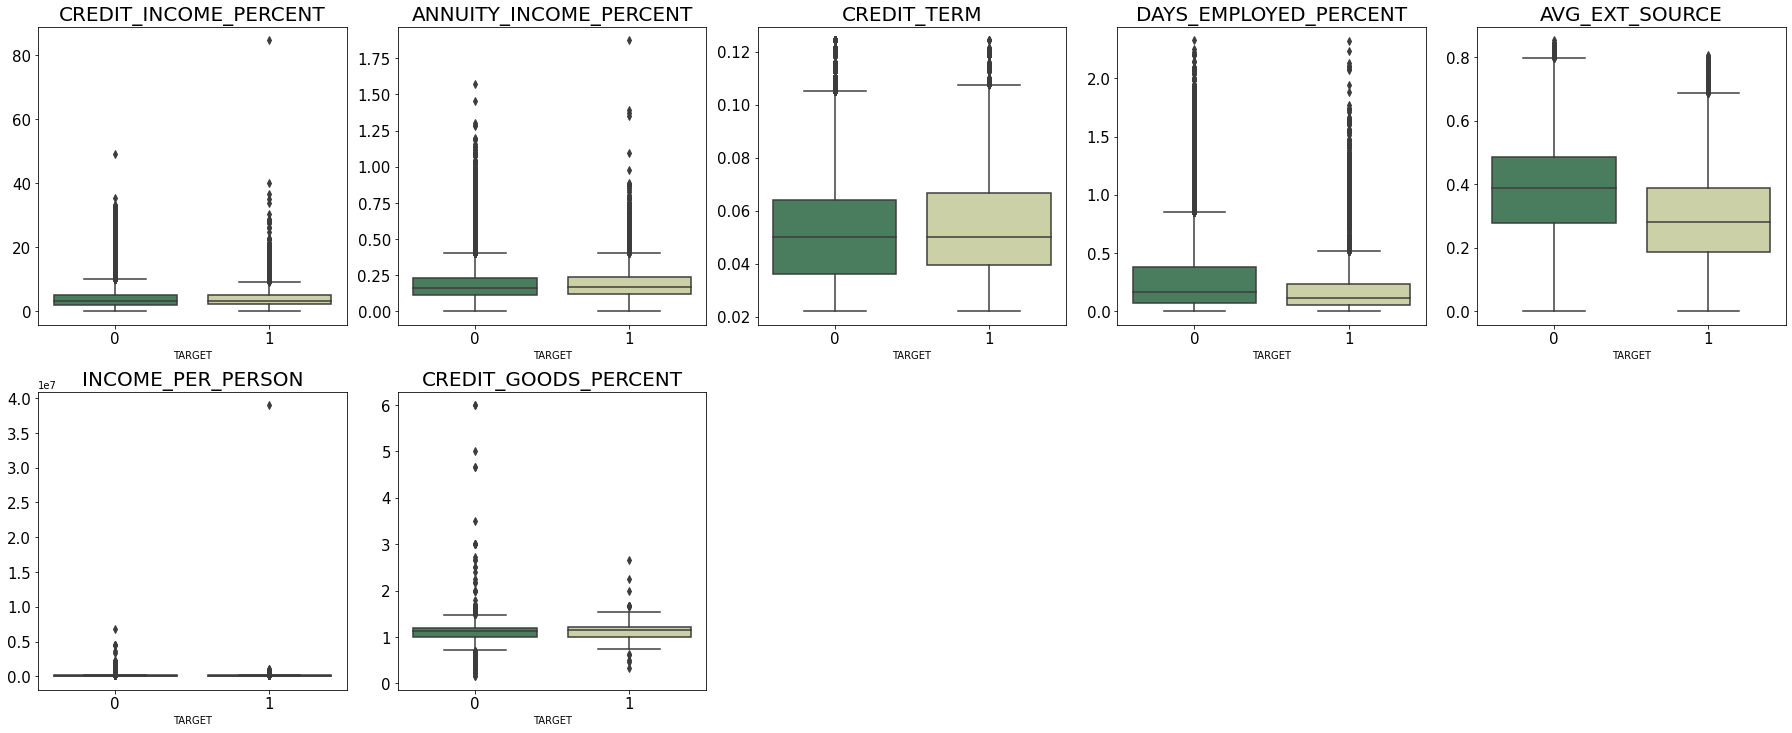

,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,AVG_EXT_SOURCE,INCOME_PER_PERSON,CREDIT_GOODS_PERCENT
TARGET,,,,,,,
0,3.963729,0.180530,0.053610,0.283721,0.388642,93303.290305,1.120443
1,3.887438,0.185482,0.054659,0.214460,0.289387,90857.950745,1.152056


TARGET,p_value,result
"""ANOVA Test""",,
AVG_EXT_SOURCE,0.000000e+00,reject H0 (significant)
CREDIT_GOODS_PERCENT,0.000000e+00,reject H0 (significant)
DAYS_EMPLOYED_PERCENT,1.022195e-287,reject H0 (significant)
ANNUITY_INCOME_PERCENT,2.557298e-15,reject H0 (significant)
CREDIT_TERM,1.858119e-12,reject H0 (significant)
CREDIT_INCOME_PERCENT,1.828711e-05,reject H0 (significant)
INCOME_PER_PERSON,2.683730e-04,reject H0 (significant)


In [42]:
# 'creation_columns' data
fig = plt.figure(figsize = (25, 25))
i = 1
for col in app_train[creation_columns].columns:
    plt.subplot(5, 5, i)
    ax = sns.boxplot(y = app_train[col], x = app_train['TARGET'], palette = ['#42855B', '#D2D79F'])

    ax.set(ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 20)
    plt.xticks(rotation = 0, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.tight_layout()
    i += 1
plt.show()
display(app_train[creation_columns + ['TARGET']].groupby('TARGET').agg('mean'))

# check the features with hypothesis testing
ANOVA_creation = ANOVA_test(df = app_train, 
                            columns = app_train[creation_columns].columns, 
                            target = 'TARGET', alpha = 0.05)
display(ANOVA_creation)

## Merging with other sources

Create new features for `app_train` and `app_test` from other data sources such as `bureau`, `bureau_balance`, `previous_app`, `credit_card_balance`, `installments_payments`, and `POS_CASH_balance` by aggregating their feature values based on grouping by a selected unique identifier such as `SK_ID_CURR`, `SK_ID_PREV`, or `SK_ID_BUREAU`.

In [43]:
# helper function to group by a dataframe and aggregate their numerical values with some aggregation functions
def groupby_agg_numerical(df, group_by, df_name, agg_func = ['count', 'mean', 'max', 'min', 'sum']):
    """function to group the records in df on a selected feature,
       then aggregate their record values based on predefined aggregate function in 'agg_func' list
    """
    # remove other unique ID
    for col in df.columns:
        if col != group_by and 'SK_ID' in col:
            df = df.drop(col, axis = 1)
            
    # select only numerical features
    df = df.select_dtypes('number') 
    
    # group by the selected columns in 'group_by' and aggregate using function in 'agg_func'
    df = df.groupby(group_by).agg(agg_func).reset_index()
    
    # create new column names
    new_column_names = [group_by]
    for column in df.columns:
        if column[0] != group_by:
            new_column_names.append(df_name + '_' + '_'.join(column))
    df.columns = df.columns.droplevel()
    df.columns = new_column_names
    return df

In [44]:
# helper function to count each record based on group by feature
def groupby_count_categorical(df, group_by, df_name, cat = 'object'):
    """function to ohe-hot-encode categorical features in df, then group the records on a selected feature,
       then aggregate their record values by sum and mean to get the count and normalized count of each group
    """
    # perform one hot encoding on object/category dtypes
    temp_df = df.copy()
    df = pd.get_dummies(df.select_dtypes(cat))
    df[group_by] = temp_df[group_by]
    
    # group by and aggregate with mean and sum
    df = df.groupby(group_by).agg(['sum', 'mean']).reset_index()
    
    # create new column names
    new_column_names = [group_by]
    for column in df.columns.levels[0]:
        if column != group_by:
            for stat in ['count', 'count_norm']:
                new_column_names.append(df_name + '_' + column + '_' + stat)
    df.columns = df.columns.droplevel()
    df.columns = new_column_names
    return df

In [45]:
# helper function to aggregate the level 2 entity
def aggregate_client(df, group_by, df_name, cat, agg_func = ['count', 'mean', 'max', 'min', 'sum']):
    if 'object' in df.dtypes.values or 'category' in df.dtypes.values:
        child_agg = groupby_agg_numerical(df, group_by[0], df_name[0], agg_func = agg_func) # numerical
        child_counts = groupby_count_categorical(df, group_by[0], df_name[0], cat = cat)    # cateforical
        child = child_agg.merge(child_counts, on = group_by[0], how = 'outer')
        child = df[group_by].merge(child, on = group_by[0], how = 'left')
        parent = groupby_agg_numerical(child, group_by[1], df_name[1], agg_func = agg_func)
    else:
        child = groupby_agg_numerical(df, group_by[0], df_name[0], agg_func = agg_func)     # numerical
        child = df[group_by].merge(child, on = group_by[0], how = 'left')
        parent = groupby_agg_numerical(child, group_by[1], df_name[1], agg_func = agg_func)
    return parent

import sys
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df_temp, print_info = False):
    df = df_temp.copy()
    original_memory = df.memory_usage().sum()
    # Iterate through each column
    for c in df:
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32) 
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
    return df

### Merging with bureau and bureau_balance

- The feature names after merging the `app_train` and `app_test` with `bureau` and `bureau_balance` are stored in `bureau_app_columns`.

In [46]:
# aggregate 'bureau' based on 'SK_ID_CURR'
bureau_agg = groupby_agg_numerical(bureau, 'SK_ID_CURR', 'bureau',  agg_func = ['count', 'mean', 'max', 'min', 'sum']) 
# display(bureau_agg.head())
print('bureau_agg shape:', bureau_agg.shape)

# count 'bureau' based on 'SK_ID_CURR'
bureau_counts = groupby_count_categorical(bureau, 'SK_ID_CURR', 'bureau')
# display(bureau_counts.head())
print('bureau_counts shape:', bureau_counts.shape)

# aggregate 'bureau_balance' based on 'SK_ID_BUREAU'
bureau_balance_agg = groupby_agg_numerical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance', agg_func = ['count', 'mean', 'max', 'min', 'sum'])                                      
# display(bureau_balance_agg.head())
print('bureau_balance_agg shape:', bureau_balance_agg.shape)

# count 'bureau_balance' based on 'SK_ID_BUREAU'
bureau_balance_counts = groupby_count_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
# display(bureau_balance_counts.head())
print('bureau_balance_counts shape:', bureau_balance_counts.shape)

bureau_agg shape: (305811, 61)
bureau_counts shape: (305811, 47)
bureau_balance_agg shape: (817395, 6)
bureau_balance_counts shape: (817395, 17)


In [47]:
# merge together 'bureau_balance_agg' and 'bureau_balance_counts' and merge to include 'SK_ID_CURR'
bureau_balance_loan = bureau_balance_agg.merge(bureau_balance_counts, on = 'SK_ID_BUREAU', how = 'outer')
bureau_balance_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_balance_loan, on = 'SK_ID_BUREAU', how = 'left')
# display(bureau_balance_loan.head())
print('bureau_balance_loan shape:', bureau_balance_loan.shape)

# aggregate 'bureau_balance_loan' based on 'SK_ID_CURR'
bureau_balance_client = groupby_agg_numerical(bureau_balance_loan, 'SK_ID_CURR', 'client',  agg_func = ['count', 'mean', 'max', 'min', 'sum']) 
# display(bureau_balance_client.head())
print('bureau_balance_client shape:', bureau_balance_client.shape)

bureau_balance_loan shape: (1716428, 23)
bureau_balance_client shape: (305811, 106)


In [48]:
%%time
# merge 'bureau_agg' with 'app_train' and 'app_test'
app_train = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# merge 'bureau_counts' with 'app_train' and 'app_test'
app_train = app_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# merge 'bureau_balance_loan' with 'app_train' and 'app_test'
app_train = app_train.merge(bureau_balance_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_balance_client, on = 'SK_ID_CURR', how = 'left')

Wall time: 18 s


In [49]:
# get all columns after merging with 'bureau' and 'bureau_balance'
all_columns = list(bureau_agg.columns) + list(bureau_counts.columns) + list(bureau_balance_client.columns)
all_columns = [col for col in all_columns if col not in ['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']]

In [50]:
bureau_app_columns_missing = missing_values_table(app_train[all_columns])
bureau_app_columns_missing

You are selecting dataframe which has "211" columns
There are "211" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
bureau_AMT_ANNUITY_mean,227502,73.982,307511
bureau_AMT_ANNUITY_max,227502,73.982,307511
bureau_AMT_ANNUITY_min,227502,73.982,307511
client_bureau_balance_STATUS_4_count_mean,215280,70.007,307511
client_bureau_balance_STATUS_3_count_mean,215280,70.007,307511
...,...,...,...
bureau_CREDIT_TYPE_Consumer credit_count_norm,44020,14.315,307511
bureau_CREDIT_TYPE_Credit card_count,44020,14.315,307511
bureau_CREDIT_TYPE_Credit card_count_norm,44020,14.315,307511
bureau_CREDIT_TYPE_Interbank credit_count,44020,14.315,307511


In [51]:
%%time
# check the features with hypothesis testing
ANOVA_bureau = ANOVA_test(df = app_train, 
                          columns = app_train[all_columns].columns, 
                          target = 'TARGET', alpha = 0.05)
display(ANOVA_bureau)

TARGET,p_value,result
"""ANOVA Test""",,
bureau_DAYS_CREDIT_mean,0.000000e+00,reject H0 (significant)
bureau_DAYS_CREDIT_min,0.000000e+00,reject H0 (significant)
bureau_CREDIT_ACTIVE_Active_count_norm,0.000000e+00,reject H0 (significant)
bureau_CREDIT_ACTIVE_Closed_count_norm,0.000000e+00,reject H0 (significant)
bureau_DAYS_CREDIT_UPDATE_mean,7.471337e-275,reject H0 (significant)
...,...,...
bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,8.830917e-01,fail to reject H0
client_bureau_balance_STATUS_X_count_norm_mean,9.013439e-01,fail to reject H0
bureau_AMT_CREDIT_SUM_DEBT_min,9.025868e-01,fail to reject H0


Wall time: 23.1 s


In [52]:
significant = list(ANOVA_bureau[ANOVA_bureau.result == 'reject H0 (significant)'].index)
bureau_app_columns = [col for col in all_columns if col in significant]
print('Total created features from "bureau" and "bureau_balance":', len(all_columns))
print('---> selected significant features:', len(bureau_app_columns))

Total created features from "bureau" and "bureau_balance": 211
---> selected significant features: 166


In [53]:
# free up some memories
del bureau, bureau_balance, bureau_agg, bureau_counts, bureau_balance_agg, bureau_balance_counts, bureau_balance_loan, bureau_balance_client

### Merging with previous_app, credit_card_balance, installments_payments, and POS_CASH_balance

- The feature names after merging the `app_train` and `app_test` with `previous_app`, `credit_card_balance`, `installments_payments`, and `POS_CASH_balance` are stored in `previous_app_columns`.

In [54]:
%%time
# aggregate 'previous_app' based on 'SK_ID_CURR'
previous_app_agg = groupby_agg_numerical(previous_app, 'SK_ID_CURR', 'previous_app',  agg_func = ['count', 'mean', 'max', 'min', 'sum']) 
# display(previous_app_agg.head())
print('previous_app_agg shape:', previous_app_agg.shape)

# count 'previous_app' based on 'SK_ID_CURR'
previous_app_counts = groupby_count_categorical(previous_app, 'SK_ID_CURR', 'previous_app')
# display(previous_app_counts.head())
print('previous_app_counts shape:', previous_app_counts.shape)

previous_app_agg shape: (338857, 96)
previous_app_counts shape: (338857, 287)
Wall time: 40.1 s


In [55]:
%%time
POS_CASH_balance = convert_types(POS_CASH_balance, print_info = True)
cash_client = aggregate_client(df = POS_CASH_balance, 
                               group_by = ['SK_ID_PREV', 'SK_ID_CURR'], cat = 'category',
                               df_name = ['cash', 'client'], agg_func = ['mean', 'sum'])
# display(cash_client.head())
print('cash_client shape:', cash_client.shape)

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.
cash_client shape: (337252, 57)
Wall time: 1min 32s


In [56]:
%%time
installments_payments = convert_types(installments_payments, print_info = True)
installments_client = aggregate_client(df = installments_payments, 
                                       group_by = ['SK_ID_PREV', 'SK_ID_CURR'], cat = 'category',
                                       df_name = ['installments', 'client'], agg_func = ['mean', 'sum'])
# display(installments_client.head())
print('installments_client shape:', installments_client.shape)

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.
installments_client shape: (339587, 25)
Wall time: 28.9 s


In [57]:
%%time
credit_card_balance = convert_types(credit_card_balance, print_info = True)
credit_client = aggregate_client(df = credit_card_balance, 
                                 group_by = ['SK_ID_PREV', 'SK_ID_CURR'], cat = 'category', 
                                 df_name = ['credit', 'client'], agg_func = ['mean', 'sum'])
# display(credit_client.head())
print('credit_client shape:', credit_client.shape)

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.
credit_client shape: (103558, 109)
Wall time: 26.3 s


In [58]:
%%time
# merge 'previous_app_agg' with 'app_train' and 'app_test'
app_train = app_train.merge(previous_app_agg, on ='SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_app_agg, on ='SK_ID_CURR', how = 'left')

# merge 'previous_app_counts' with 'app_train' and 'app_test'
app_train = app_train.merge(previous_app_counts, on ='SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_app_counts, on ='SK_ID_CURR', how = 'left')

# merge 'cash_client' with 'app_train' and 'app_test'
app_train = app_train.merge(cash_client, on ='SK_ID_CURR', how = 'left')
app_test = app_test.merge(cash_client, on ='SK_ID_CURR', how = 'left')

# merge 'installments_client' with 'app_train' and 'app_test'
app_train = app_train.merge(installments_client, on ='SK_ID_CURR', how = 'left')
app_test = app_test.merge(installments_client, on ='SK_ID_CURR', how = 'left')

# merge 'credit_client' with 'app_train' and 'app_test'
app_train = app_train.merge(credit_client, on ='SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_client, on ='SK_ID_CURR', how = 'left')

print(app_train.shape)
print(app_test.shape)

(307511, 928)
(48744, 927)
Wall time: 2min 46s


In [59]:
# get the columns after merging with 'previous_app', 'credit_card_balance', 'installments_payments', 'POS_CASH_balance'
all_columns = list(previous_app_agg.columns) + list(previous_app_counts.columns) + \
              list(cash_client.columns) + list(installments_client.columns) + list(credit_client.columns)
all_columns = [col for col in all_columns if col not in ['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']]

# exclude columns with only 1 unique value
temp_unique = app_train[all_columns].nunique()
all_columns = list(temp_unique[temp_unique != 1].index)

In [60]:
# check missing values
previous_app_columns_missing = missing_values_table(app_train[all_columns])
display(previous_app_columns_missing)

# filter to include missing values less than 80%
previous_app_columns_missing = previous_app_columns_missing[previous_app_columns_missing['% of Total Values'] < 80]
all_columns = list(previous_app_columns_missing.index)

You are selecting dataframe which has "567" columns
There are "567" columns that have missing values.


,Missing Values,% of Total Values,Total Rows
previous_app_RATE_INTEREST_PRIVILEGED_mean,302902,98.501,307511
previous_app_RATE_INTEREST_PRIVILEGED_min,302902,98.501,307511
previous_app_RATE_INTEREST_PRIVILEGED_max,302902,98.501,307511
previous_app_RATE_INTEREST_PRIMARY_mean,302902,98.501,307511
previous_app_RATE_INTEREST_PRIMARY_max,302902,98.501,307511
...,...,...,...
client_installments_NUM_INSTALMENT_VERSION_mean_sum,15868,5.160,307511
client_installments_NUM_INSTALMENT_VERSION_sum_mean,15868,5.160,307511
client_installments_NUM_INSTALMENT_VERSION_sum_sum,15868,5.160,307511
client_installments_NUM_INSTALMENT_NUMBER_mean_mean,15868,5.160,307511


In [61]:
%%time
# check the features with hypothesis testing
ANOVA_previous_app = ANOVA_test(df = app_train, 
                                columns = app_train[all_columns].columns, 
                                target = 'TARGET', alpha = 0.05)
display(ANOVA_previous_app)

TARGET,p_value,result
"""ANOVA Test""",,
previous_app_NAME_CONTRACT_STATUS_Refused_count_norm,0.000000e+00,reject H0 (significant)
previous_app_CODE_REJECT_REASON_XAP_count_norm,0.000000e+00,reject H0 (significant)
previous_app_NAME_CONTRACT_STATUS_Refused_count,1.353410e-265,reject H0 (significant)
previous_app_NAME_CONTRACT_STATUS_Approved_count_norm,6.899536e-258,reject H0 (significant)
previous_app_NAME_PRODUCT_TYPE_walk-in_count,9.815426e-251,reject H0 (significant)
...,...,...
previous_app_NAME_CASH_LOAN_PURPOSE_Money for a third person_count_norm,9.478822e-01,fail to reject H0
client_credit_CNT_DRAWINGS_OTHER_CURRENT_sum_mean,9.592203e-01,fail to reject H0
previous_app_NAME_PAYMENT_TYPE_Non-cash from your account_count,9.642784e-01,fail to reject H0


Wall time: 55.6 s


In [62]:
significant = list(ANOVA_previous_app[ANOVA_previous_app.result == 'reject H0 (significant)'].index)
previous_app_columns = [col for col in all_columns if col in significant]
print('Total created features from "previous_app", "credit_card_balance", "installments_payments", "POS_CASH_balance":', len(all_columns))
print('---> selected significant features:', len(previous_app_columns))

Total created features from "previous_app", "credit_card_balance", "installments_payments", "POS_CASH_balance": 554
---> selected significant features: 417


# Final train and test dataset

## Preprocessing before saving the file

In [63]:
# helper function add 'column_name' to 'list_of_columns'
def add_column(list_of_columns, column_name):
    if column_name in list_of_columns:
        print('"{}" is already there'.format(column_name))
    else:
        list_of_columns.append(column_name)
        print('We have add a new column "{}"'.format(column_name))
        
# helper function remove 'column_name' from 'list_of_columns'
def remove_column(list_of_columns, column_name):
    if column_name not in list_of_columns:
        print('"{}" is not there'.format(column_name))
    else:
        list_of_columns.remove(column_name)
        print('We have remove "{}" column'.format(column_name))

In [64]:
add_column(list_of_columns = cat_columns, 
           column_name = 'YEARS_BIRTH_SEGMENT')

We have add a new column "YEARS_BIRTH_SEGMENT"


In [65]:
remove_column(list_of_columns = num_columns, 
              column_name = 'DAYS_BIRTH')

We have remove "DAYS_BIRTH" column


In [66]:
app_train['CODE_GENDER'] = pd.Categorical(app_train['CODE_GENDER'], ordered = True, categories = ['F', 'M'])
app_test['CODE_GENDER'] = pd.Categorical(app_test['CODE_GENDER'], ordered = True, categories = ['F', 'M'])

app_train['FLAG_OWN_CAR'] = pd.Categorical(app_train['FLAG_OWN_CAR'], ordered = True, categories = ['N', 'Y'])
app_test['FLAG_OWN_CAR'] = pd.Categorical(app_test['FLAG_OWN_CAR'], ordered = True, categories = ['N', 'Y'])

app_train['FLAG_OWN_REALTY'] = pd.Categorical(app_train['FLAG_OWN_REALTY'], ordered = True, categories = ['N', 'Y'])
app_test['FLAG_OWN_REALTY'] = pd.Categorical(app_test['FLAG_OWN_REALTY'], ordered = True, categories = ['N', 'Y'])

# create ord_columns and nom_columns
ord_columns = ['YEARS_BIRTH_SEGMENT', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
nom_columns = [col for col in cat_columns if col not in ord_columns]

## Save the train data, test data, and column names for modeling purpose

In [67]:
all_columns = num_columns + nom_columns + ord_columns + poly_columns + creation_columns + bureau_app_columns + previous_app_columns
print('Total features used for modeling:', len(all_columns), 'features + 2 variables, "SK_ID_CURR" and "TARGET"')

Total features used for modeling: 707 features + 2 variables, "SK_ID_CURR" and "TARGET"


In [68]:
print('app_train shape:', app_train.shape)
print('app_test shape:', app_test.shape)

app_train shape: (307511, 928)
app_test shape: (48744, 927)


In [69]:
# include only columns from 'all_columns' list
app_train_final = app_train[['SK_ID_CURR', 'TARGET'] + all_columns].copy()
app_test_final = app_test[['SK_ID_CURR'] + all_columns].copy()

print('app_train_final shape:', app_train_final.shape)
print('app_test_final shape:', app_test_final.shape)

app_train_final shape: (307511, 709)
app_test_final shape: (48744, 708)


In [70]:
%%time
app_train_final.to_csv('final train and test dataset/app_train_final.csv', index = False)

Wall time: 2min 42s


In [71]:
%%time
app_test_final.to_csv('final train and test dataset/app_test_final.csv', index = False)

Wall time: 24.6 s


In [72]:
%%time
column_names = pd.DataFrame({'variable':['num_columns', 'cat_columns', 'nom_columns', 'ord_columns', 'poly_columns', 'creation_columns', 'bureau_app_columns', 'previous_app_columns'],
                             'list':[num_columns, cat_columns, nom_columns, ord_columns, poly_columns, creation_columns, bureau_app_columns, previous_app_columns]})
column_names.to_csv('final train and test dataset/column_names.csv', index = False)
column_names

Wall time: 8.97 ms


,variable,list
0,num_columns,"[EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1, DAY..."
1,cat_columns,"[OCCUPATION_TYPE, NAME_INCOME_TYPE, ORGANIZATI..."
2,nom_columns,"[OCCUPATION_TYPE, NAME_INCOME_TYPE, ORGANIZATI..."
3,ord_columns,"[YEARS_BIRTH_SEGMENT, CODE_GENDER, FLAG_OWN_CA..."
4,poly_columns,"[EXT_SOURCE_1^2, EXT_SOURCE_1 EXT_SOURCE_2, EX..."
5,creation_columns,"[CREDIT_INCOME_PERCENT, ANNUITY_INCOME_PERCENT..."
6,bureau_app_columns,"[bureau_DAYS_CREDIT_count, bureau_DAYS_CREDIT_..."
7,previous_app_columns,[client_credit_AMT_RECEIVABLE_PRINCIPAL_mean_s...


## Check the column names

In [73]:
temp = [num_columns, cat_columns, nom_columns, ord_columns, poly_columns, creation_columns, bureau_app_columns, previous_app_columns]
for i, val in enumerate(column_names.variable):
    print('df-{} == list-{} ? ---> {}'.format(val, val, column_names[column_names['variable'] == val]['list'].tolist()[0] == temp[i]))

df-num_columns == list-num_columns ? ---> True
df-cat_columns == list-cat_columns ? ---> True
df-nom_columns == list-nom_columns ? ---> True
df-ord_columns == list-ord_columns ? ---> True
df-poly_columns == list-poly_columns ? ---> True
df-creation_columns == list-creation_columns ? ---> True
df-bureau_app_columns == list-bureau_app_columns ? ---> True
df-previous_app_columns == list-previous_app_columns ? ---> True


In [74]:
print('shape of "num_columns":', len(num_columns), '\n               ↓')
print(num_columns)

shape of "num_columns": 84 
               ↓
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'AMT_CREDIT', 'FLAG_DOCUMENT_6', 'FLAG_WORK_PHONE', 'HOUR_APPR_PROCESS_START', 'FLAG_PHONE', 'TOTALAREA_MODE', 'ELEVATORS_AVG', 'LIVINGAREA_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI', 'ELEVATORS_MODE', 'OWN_CAR_AGE', 'LIVINGAREA_MODE', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'CNT_CHILDREN', 'APARTMENTS_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'ENTRANCES_AVG

In [75]:
print('shape of "cat_columns":', len(cat_columns), '\n               ↓')
print(cat_columns)

print()

print('shape of "nom_columns":', len(nom_columns), '\n               ↓')
print(nom_columns)

print()

print('shape of "ord_columns":', len(ord_columns), '\n               ↓')
print(ord_columns)

shape of "cat_columns": 17 
               ↓
['OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'NAME_TYPE_SUITE', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'WEEKDAY_APPR_PROCESS_START', 'YEARS_BIRTH_SEGMENT']

shape of "nom_columns": 13 
               ↓
['OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_CONTRACT_TYPE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'NAME_TYPE_SUITE', 'FONDKAPREMONT_MODE', 'WEEKDAY_APPR_PROCESS_START']

shape of "ord_columns": 4 
               ↓
['YEARS_BIRTH_SEGMENT', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [76]:
print('shape of "poly_columns":', len(poly_columns), '\n               ↓')
print(poly_columns)

shape of "poly_columns": 16 
               ↓
['EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_3^2', 'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1 EXT_SOURCE_2^2', 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_1 EXT_SOURCE_3^2', 'EXT_SOURCE_2^3', 'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2 EXT_SOURCE_3^2', 'EXT_SOURCE_3^3']


In [77]:
print('shape of "creation_columns":', len(creation_columns), '\n               ↓')
print(creation_columns)

shape of "creation_columns": 7 
               ↓
['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'AVG_EXT_SOURCE', 'INCOME_PER_PERSON', 'CREDIT_GOODS_PERCENT']


In [78]:
print('shape of "num_columns":', len(bureau_app_columns), '\n               ↓')
print(bureau_app_columns)

shape of "num_columns": 166 
               ↓
['bureau_DAYS_CREDIT_count', 'bureau_DAYS_CREDIT_mean', 'bureau_DAYS_CREDIT_max', 'bureau_DAYS_CREDIT_min', 'bureau_DAYS_CREDIT_sum', 'bureau_CREDIT_DAY_OVERDUE_count', 'bureau_CREDIT_DAY_OVERDUE_mean', 'bureau_CREDIT_DAY_OVERDUE_max', 'bureau_CREDIT_DAY_OVERDUE_min', 'bureau_CREDIT_DAY_OVERDUE_sum', 'bureau_DAYS_CREDIT_ENDDATE_count', 'bureau_DAYS_CREDIT_ENDDATE_mean', 'bureau_DAYS_CREDIT_ENDDATE_max', 'bureau_DAYS_CREDIT_ENDDATE_min', 'bureau_DAYS_CREDIT_ENDDATE_sum', 'bureau_DAYS_ENDDATE_FACT_count', 'bureau_DAYS_ENDDATE_FACT_mean', 'bureau_DAYS_ENDDATE_FACT_max', 'bureau_DAYS_ENDDATE_FACT_min', 'bureau_DAYS_ENDDATE_FACT_sum', 'bureau_AMT_CREDIT_MAX_OVERDUE_count', 'bureau_CNT_CREDIT_PROLONG_count', 'bureau_CNT_CREDIT_PROLONG_max', 'bureau_CNT_CREDIT_PROLONG_sum', 'bureau_AMT_CREDIT_SUM_count', 'bureau_AMT_CREDIT_SUM_mean', 'bureau_AMT_CREDIT_SUM_max', 'bureau_AMT_CREDIT_SUM_min', 'bureau_AMT_CREDIT_SUM_sum', 'bureau_AMT_CREDIT_SUM_DEBT_

In [79]:
print('shape of "previous_app_columns":', len(previous_app_columns), '\n               ↓')
print(previous_app_columns)

shape of "previous_app_columns": 417 
               ↓
['client_credit_AMT_RECEIVABLE_PRINCIPAL_mean_sum', 'client_credit_AMT_RECEIVABLE_PRINCIPAL_sum_sum', 'client_credit_AMT_PAYMENT_TOTAL_CURRENT_sum_sum', 'client_credit_AMT_RECEIVABLE_PRINCIPAL_sum_mean', 'client_credit_AMT_RECEIVABLE_PRINCIPAL_mean_mean', 'client_credit_AMT_RECIVABLE_mean_sum', 'client_credit_AMT_RECIVABLE_mean_mean', 'client_credit_AMT_PAYMENT_TOTAL_CURRENT_mean_mean', 'client_credit_AMT_RECIVABLE_sum_mean', 'client_credit_AMT_RECIVABLE_sum_sum', 'client_credit_AMT_TOTAL_RECEIVABLE_mean_mean', 'client_credit_AMT_TOTAL_RECEIVABLE_mean_sum', 'client_credit_AMT_TOTAL_RECEIVABLE_sum_mean', 'client_credit_AMT_TOTAL_RECEIVABLE_sum_sum', 'client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_sum', 'client_credit_CNT_DRAWINGS_ATM_CURRENT_sum_mean', 'client_credit_CNT_DRAWINGS_ATM_CURRENT_sum_sum', 'client_credit_CNT_DRAWINGS_CURRENT_mean_mean', 'client_credit_CNT_DRAWINGS_CURRENT_mean_sum', 'client_credit_CNT_DRAWINGS_CURRENT_sum_m